In [1]:
# Dependencies
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# Classes
class State():
    def __init__(self, name):
        self.name = name
        self.final = False
        self.edges = []

    def add_edge(self, destiny, transition, output=0):
        edge = Edge(self.name, destiny, transition, output)
        self.edges.append(edge)

    def add_state_to_fst(self, fst):
        fst.add_node(self.name, final=self.final)

    def add_edges_to_fst(self, fst):
        for edge in self.edges:
            fst.add_edge(edge.origin, edge.destiny,
                         transition=edge.transition, output=edge.output)

    def set_final(self, is_final):
        self.final = is_final

    def is_equal(self, state):
        if self.final != state.final:
            # print("Final Diferente")
            return False
        if len(self.edges) != len(state.edges):
            # print("Numero edges diferente")
            return False
        for edge in self.edges:
            found_equivalent = False
            for state_edge in state.edges:
                if (edge.destiny == state_edge.destiny and edge.transition == state_edge.transition and edge.output == state_edge.output):
                    found_equivalent = True
                    break
            if found_equivalent:
                continue
            # print("Nao achou equivalente")
            return False
        return True

    def transition(self, letter):
        for edge in self.edges:
            if (edge.transition == letter):
                return edge.destiny
        return None

    def output(self, letter):
        for edge in self.edges:
            if (edge.transition == letter):
                return edge.output
        return None

    def clear(self):
        self.final = False
        self.edges = []

    def copy(self):
        new_state = State(self.name)
        new_state.set_final(self.final)
        for edge in self.edges:
            new_state.add_edge(edge.destiny, edge.transition, edge.output)
        return new_state

    def rename(self, name):
        self.name = name
        for edge in self.edges:
            edge.origin = name

    def remove_edge(self, destiny, transition):
        to_be_removed_edge = None
        for edge in self.edges:
            if (edge.destiny == destiny and edge.transition == transition):
                to_be_removed_edge = edge
                break
        if to_be_removed_edge != None:
            print("Removi")
            self.edges.remove(to_be_removed_edge)


class Edge():
    def __init__(self, origin, destiny, transition, output):
        self.origin = origin
        self.destiny = destiny
        self.transition = transition
        self.output = output


In [3]:
# Utils
def findMinimizedState(state, minimal_states):
    for frozen_state in minimal_states:
        if frozen_state.is_equal(state):
            print("Estado Equivalente, {}, Final:{}, Edges:{}".format(frozen_state.name, frozen_state.final, len(frozen_state.edges)))
            return frozen_state
    new_state = state.copy()
    new_state.rename(len(minimal_states))
    print("Novo Estado Minimizado, {}, Final:{}, Edges:{}".format(new_state.name, new_state.final, len(new_state.edges)))
    # for edge in state.edges:
    #     print(edge.origin)
    #     print(edge.destiny)
    #     print(edge.transition)
    minimal_states.append(new_state)
    # for stat in minimal_states:
    #     print("Estado: {}, Final:{}, Edges:{}".format(stat.name, stat.final, len(stat.edges)))
    return new_state

def findMaxWordSize(dictionary):
    max_word_size = 0
    for word in dictionary.keys():
        if len(word) > max_word_size:
            max_word_size = len(word)
    return max_word_size

In [4]:
# Create Minimal Transducer
def create_minimal_transducer(dictionary):
    # Initial

    fst = nx.DiGraph()
    minimal_states = []
    max_word_size = findMaxWordSize(dictionary)
    print(max_word_size)
    temp_states = []
    for i in range(0, max_word_size + 1):
        temp_state = State(i)
        temp_states.append(temp_state)

    # Algorithm

    prev_word = ""
    current_word = ""

    for word, index in dictionary.items():
        current_word = word
        print(current_word)
        # Longest Prefix
        prefix_len = 0
        while (prefix_len < len(current_word) and prefix_len < len(prev_word) and prev_word[prefix_len] == current_word[prefix_len]):
            prefix_len = prefix_len + 1
        # Minimize States from Suffix of the Previous Word
        for i in range(len(prev_word),prefix_len, -1):
            temp_states[i-1].remove_edge(temp_states[i].name,prev_word[i-1])
            temp_states[i-1].add_edge(findMinimizedState(temp_states[i],minimal_states).name,prev_word[i-1])
            temp_states[i].clear()
        # Initializes Tail States for the Current Word
        for i in range(prefix_len,len(current_word)):
            temp_states[i].add_edge(temp_states[i+1].name,current_word[i])
        if current_word != prev_word:
            temp_states[len(current_word)].set_final(True)
        # Fixing Outputs
        # for j in range(0, prefix_len):
        #     pass
        # if current_word == "":
        #     pass
        prev_word = current_word
    
    # Minimizing States for Last Word
    for i in range(len(current_word),0,-1):
        temp_states[i-1].remove_edge(temp_states[i].name,current_word[i-1])
        temp_states[i-1].add_edge(findMinimizedState(temp_states[i],minimal_states).name,current_word[i-1])
        temp_states[i].clear()
    
    # Adding starting state
    findMinimizedState(temp_states[0], minimal_states)
            

    # Creating FST based on list
    
    for state in minimal_states:
        state.add_state_to_fst(fst)
    for state in minimal_states:
        state.add_edges_to_fst(fst)
    
    return fst


In [5]:
# Create Dictionary
def create_dictionary():
    dictionary = {"jan": 1, "mar": 3, "apr": 4,
                  "may": 5, "jun": 6, "jul": 7, "aug": 8}
    dictionary = dict(sorted(dictionary.items()))
    return dictionary


In [6]:
# Read Input

def read_input(input, fst):
    state = 0
    output = 0
    for letter in input:
        current_state_edges = dict(fst[state])
        prev_state = state
        for next_state, edge_properties in current_state_edges.items():
            if edge_properties['transition'] == letter:
                state = next_state
                output += edge_properties['output']
                break
        if (state == prev_state):
            break
    return output

3
apr
aug
Removi
Novo Estado Minimizado, 0, Final:True, Edges:0
Removi
Novo Estado Minimizado, 1, Final:False, Edges:1
jan
Removi
Estado Equivalente, 0, Final:True, Edges:0
Removi
Novo Estado Minimizado, 2, Final:False, Edges:1
Removi
Novo Estado Minimizado, 3, Final:False, Edges:2
jul
Removi
Estado Equivalente, 0, Final:True, Edges:0
Removi
Novo Estado Minimizado, 4, Final:False, Edges:1
jun
Removi
Estado Equivalente, 0, Final:True, Edges:0
mar
Removi
Estado Equivalente, 0, Final:True, Edges:0
Removi
Novo Estado Minimizado, 5, Final:False, Edges:2
Removi
Novo Estado Minimizado, 6, Final:False, Edges:2
may
Removi
Estado Equivalente, 0, Final:True, Edges:0
Removi
Estado Equivalente, 0, Final:True, Edges:0
Removi
Novo Estado Minimizado, 7, Final:False, Edges:2
Removi
Novo Estado Minimizado, 8, Final:False, Edges:1
Novo Estado Minimizado, 9, Final:False, Edges:3


{(1,
  0): Text(-0.9045084714889526, -0.2938927253100516, "{'transition': 'r', 'output': 0}"),
 (2,
  0): Text(-0.6545085459947586, -0.4755282839152457, "{'transition': 'g', 'output': 0}"),
 (3,
  1): Text(-0.24999991059303284, -0.7694209218025208, "{'transition': 'p', 'output': 0}"),
 (3,
  2): Text(1.4901161193847656e-08, -0.9510564804077148, "{'transition': 'u', 'output': 0}"),
 (4,
  0): Text(-0.09549137949943542, -0.2938925166937949, "{'transition': 'n', 'output': 0}"),
 (5, 0): Text(0.0, 4.371138828673793e-08, "{'transition': 'n', 'output': 0}"),
 (6,
  4): Text(0.8090171217918396, 1.4901161193847656e-07, "{'transition': 'a', 'output': 0}"),
 (6,
  5): Text(0.904508501291275, 0.29389270941679513, "{'transition': 'u', 'output': 0}"),
 (7,
  0): Text(-0.34549160301685333, 0.4755282560971139, "{'transition': 'y', 'output': 0}"),
 (8,
  7): Text(-3.2782554626464844e-07, 0.9510564804077148, "{'transition': 'a', 'output': 0}"),
 (9,
  3): Text(-0.24999988079071045, -0.1816355288028717,

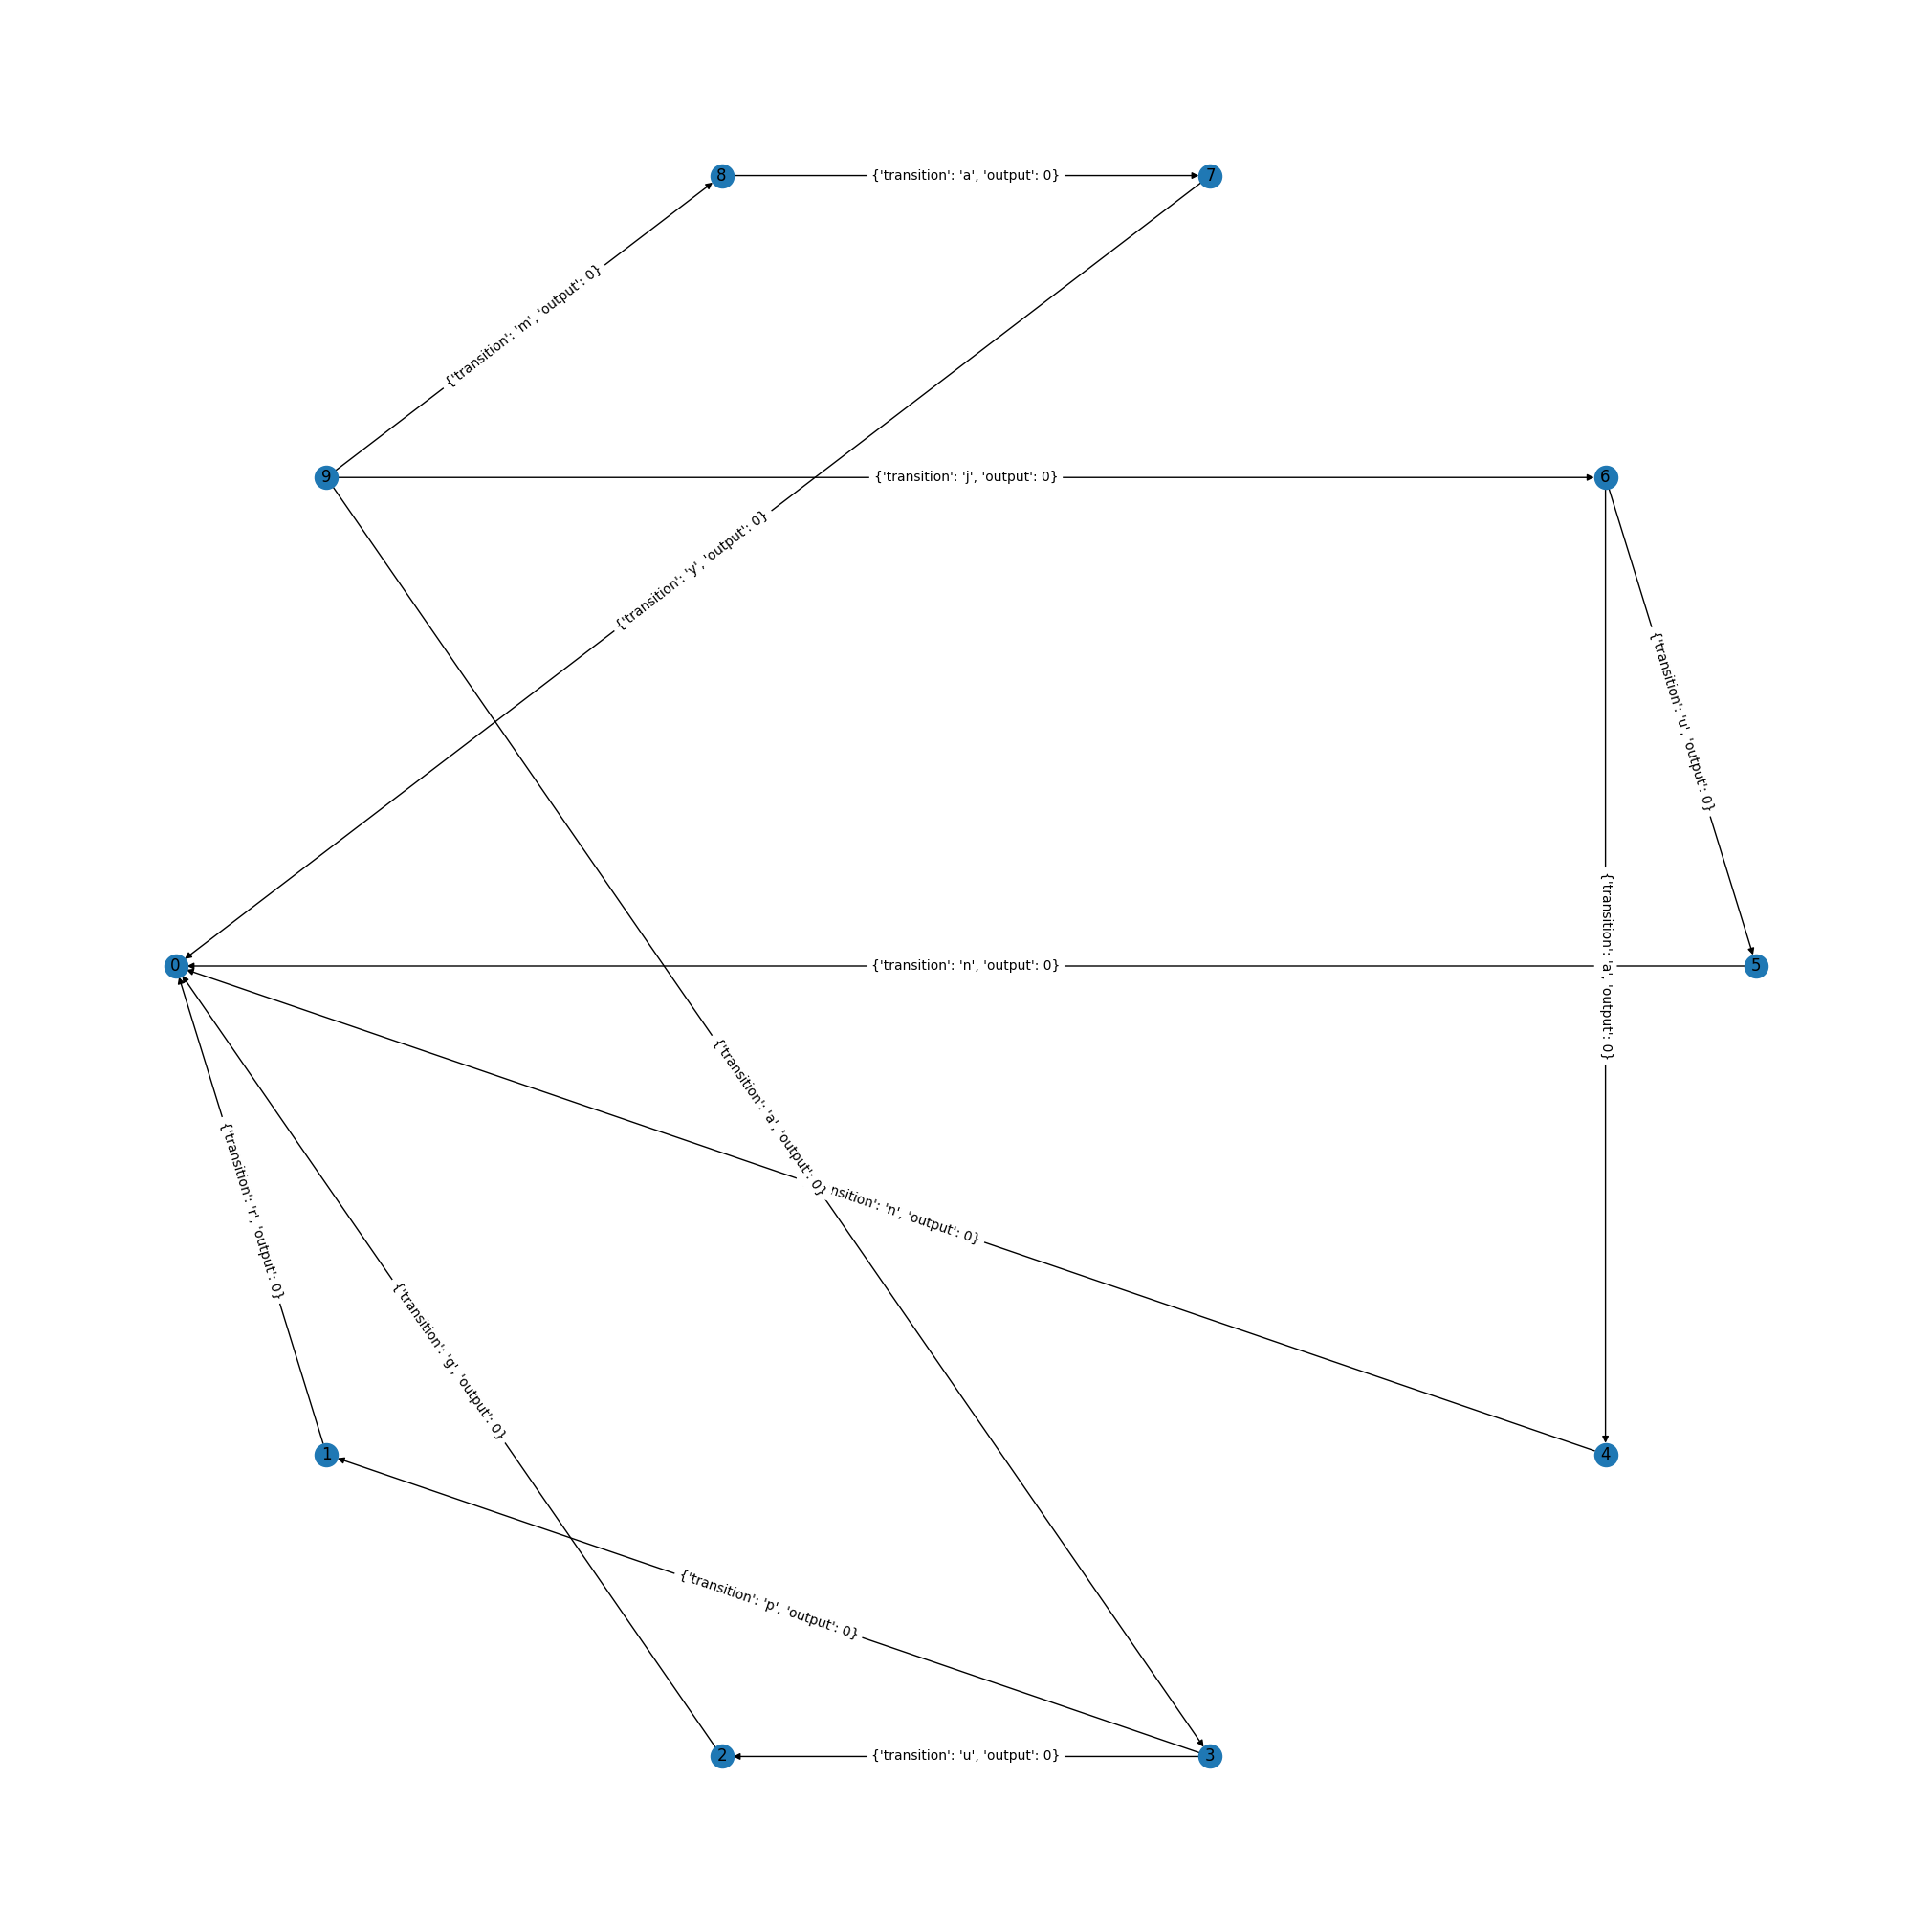

In [7]:
# Main

dictionary = create_dictionary()
fst = create_minimal_transducer(dictionary)
pos = nx.shell_layout(fst)
plt.figure(figsize=(20,20))
nx.draw(fst, pos, with_labels=True)
nx.draw_networkx_edge_labels(fst, pos)
